# COVID-19 report analysis

Utilizes the daily data reporting from Johns Hopkins University Center for Systems Science and Engineering (JHU CSSE):
https://systems.jhu.edu/

Using the introductory Data Science Tables (for reference see http://data8.org/datascience/tables.html) of introductory courses

In [38]:
# HIDDEN
# This useful nonsense should just go at the top of your notebook.
from datascience import *
%matplotlib inline
#%matplotlib notebook
import matplotlib.pyplot as plots
import numpy as np
plots.style.use('fivethirtyeight')
plots.rc('lines', linewidth=2, color='r')
from ipywidgets import interact
import ipywidgets as widgets
# datascience version number of last run of this notebook
version.__version__

'0.15.0'

In [39]:
import sys
sys.path.append(".")
from timetable import TimeTable

import locale
locale.setlocale( locale.LC_ALL, 'en_US.UTF-8' ) 

import os
import datetime

# Parsing and cleaning
def denan(v):
    return v if v != 'nan' else np.nan

def clean(tbl):
    for lbl in tbl.labels:
        tbl[lbl] = tbl.apply(denan, lbl)

def is_state(name):
    return not ',' in name
def is_county(name):
    return ',' in name
def getstate(name):
    county, state = name.split(', ')
    return state
def getcounty(name):
    county, state = name.split(', ')
    return county

# Tools for working with timestamps
def afterday(refday, day):
    return datetime.datetime.strptime(refday, "%m/%d/%y") <= datetime.datetime.strptime(day, "%m/%d/%y")

def after(trend, refday):
    return trend.where(trend.apply(lambda day: afterday(refday, day), trend.time_column))

def beforeday(refday, day):
    return datetime.datetime.strptime(refday, "%m/%d/%y") >= datetime.datetime.strptime(day, "%m/%d/%y")

def before(trend, refday):
    return trend.where(trend.apply(lambda day: beforeday(refday, day), trend.time_column))

In [40]:
# Tools for working with content
def by_country(raw_world):
    res = raw_world.drop(['Province/State', 'Lat', 'Long']).group('Country/Region', sum)
    for lbl in res.labels[1:] :
        res.relabel(lbl, lbl[:-4])
    return res

In [41]:
# Projecting growth rates

def incday(day, ndays=1):
    date =  datetime.datetime.strptime(day, "%m/%d/%y") + datetime.timedelta(days=ndays)
    return datetime.datetime.strftime(date, "%m/%d/%y")

def ave_growth(trend, window=4):
    """Average recent growth rate of single trend"""
    return np.mean(trend.take[-window:]['rate'])

def project_trend(trend, num_days, rate=None):
    if rate :
        growth_rate = rate
    else :
        growth_rate = ave_growth(trend)
    day = trend.last('Day')
    val = trend.last(1)
    growth = trend.last('new')
    pnew = trend.last('% new')
    proj = trend.copy()
    for i in range(num_days):
        day = incday(day)
        growth = round(growth * growth_rate)
        val = val + growth
        pnew = growth/val
        proj.append((day, val, growth, pnew, growth_rate))
    return proj

In [42]:
confirmedURL = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv"
deathURL = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv"
recoveredURL = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv"

In [43]:
# Raw data of confirmed cases
raw_confirmed = Table.read_table(confirmedURL)
raw_confirmed

Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20
nan,Thailand,15,101,2,3,5,7,8,8,14,14,14,19,19,19,19,25,25,25,25,32,32,32,33,33,33,33,33,34,35,35,35,35,35,35,35,35,37,40,40,41,42,42,43,43,43,47,48,50,50,50,53,59,70,75,82,114,147,177,212,272,322,411,599,599
nan,Japan,36,138,2,1,2,2,4,4,7,7,11,15,20,20,20,22,22,45,25,25,26,26,26,28,28,29,43,59,66,74,84,94,105,122,147,159,170,189,214,228,241,256,274,293,331,360,420,461,502,511,581,639,639,701,773,839,825,878,889,924,963,1007,1086,1086
nan,Singapore,1.2833,103.833,0,1,3,3,4,5,7,7,10,13,16,18,18,24,28,28,30,33,40,45,47,50,58,67,72,75,77,81,84,84,85,85,89,89,91,93,93,93,102,106,108,110,110,117,130,138,150,150,160,178,178,200,212,226,243,266,313,345,385,432,455,455
nan,Nepal,28.1667,84.25,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,2
nan,Malaysia,2.5,112.5,0,0,0,3,4,4,4,7,8,8,8,8,8,10,12,12,12,16,16,18,18,18,19,19,22,22,22,22,22,22,22,22,22,22,22,22,23,23,25,29,29,36,50,50,83,93,99,117,129,149,149,197,238,428,566,673,790,900,1030,1183,1306,1306
British Columbia,Canada,49.2827,-123.121,0,0,0,0,0,0,1,1,1,1,1,1,1,1,2,2,4,4,4,4,4,4,4,4,4,4,5,5,5,5,6,6,6,6,7,7,7,7,8,8,8,9,12,13,21,21,27,32,32,39,46,64,64,73,103,103,186,231,271,424,424,424
New South Wales,Australia,-33.8688,151.209,0,0,0,0,3,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,6,6,13,22,22,26,28,38,48,55,65,65,92,112,134,171,210,267,307,353,436,533,533
Victoria,Australia,-37.8136,144.963,0,0,0,0,1,1,1,1,2,3,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,7,7,9,9,10,10,10,11,11,15,18,21,21,36,49,57,71,94,121,121,121,229,296,296
Queensland,Australia,-28.0167,153.4,0,0,0,0,0,0,0,1,3,2,3,2,2,3,3,4,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,9,9,9,11,11,13,13,13,15,15,18,20,20,35,46,61,68,78,94,144,184,221,221,221
nan,Cambodia,11.55,104.917,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,2,2,3,3,5,7,7,7,33,35,37,51,53,84,84


In [44]:
raw_by_country = by_country(raw_confirmed)
countries_by_day = TimeTable.transpose(raw_by_country, 'Country/Region')
after(countries_by_day, "3/15/20")

Day,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,Azerbaijan,"Bahamas, The",Bahrain,Bangladesh,Barbados,Belarus,Belgium,Benin,Bhutan,Bolivia,Bosnia and Herzegovina,Brazil,Brunei,Bulgaria,Burkina Faso,Cabo Verde,Cambodia,Cameroon,Canada,Cape Verde,Central African Republic,Chad,Chile,China,Colombia,Congo (Brazzaville),Congo (Kinshasa),Costa Rica,Cote d'Ivoire,Croatia,Cruise Ship,Cuba,Cyprus,Czechia,Denmark,Djibouti,Dominica,Dominican Republic,East Timor,Ecuador,Egypt,El Salvador,Equatorial Guinea,Eritrea,Estonia,Eswatini,Ethiopia,Fiji,Finland,France,French Guiana,Gabon,"Gambia, The",Georgia,Germany,Ghana,Greece,Greenland,Grenada,Guadeloupe,Guam,Guatemala,Guernsey,Guinea,Guyana,Haiti,Holy See,Honduras,Hungary,Iceland,India,Indonesia,Iran,Iraq,Ireland,Israel,Italy,Jamaica,Japan,Jersey,Jordan,Kazakhstan,Kenya,"Korea, South",Kosovo,Kuwait,Kyrgyzstan,Latvia,Lebanon,Liberia,Liechtenstein,Lithuania,Luxembourg,Madagascar,Malaysia,Maldives,Malta,Martinique,Mauritania,Mauritius,Mayotte,Mexico,Moldova,Monaco,Mongolia,Montenegro,Morocco,Mozambique,Namibia,Nepal,Netherlands,New Zealand,Nicaragua,Niger,Nigeria,North Macedonia,Norway,Oman,Pakistan,Panama,Papua New Guinea,Paraguay,Peru,Philippines,Poland,Portugal,Puerto Rico,Qatar,Republic of the Congo,Reunion,Romania,Russia,Rwanda,Saint Lucia,Saint Vincent and the Grenadines,San Marino,Saudi Arabia,Senegal,Serbia,Seychelles,Singapore,Slovakia,Slovenia,Somalia,South Africa,Spain,Sri Lanka,Sudan,Suriname,Sweden,Switzerland,Syria,Taiwan*,Tanzania,Thailand,The Bahamas,The Gambia,Timor-Leste,Togo,Trinidad and Tobago,Tunisia,Turkey,US,Uganda,Ukraine,United Arab Emirates,United Kingdom,Uruguay,Uzbekistan,Venezuela,Vietnam,Zambia,Zimbabwe
3/15/20,16,42,48,1,0,1,45,26,297,860,23,0,214,5,0,27,886,0,1,10,24,162,50,51,3,0,7,2,252,0,1,0,74,81003,34,1,2,27,1,49,696,4,26,253,875,0,0,11,0,28,110,0,1,0,171,1,1,0,244,4523,0,1,0,33,5795,6,331,0,0,0,0,1,0,1,4,0,1,3,32,171,113,117,13938,116,129,251,24747,10,839,0,8,9,3,8162,2,112,0,30,110,0,4,12,59,0,428,13,21,9,1,0,0,41,23,2,1,0,28,0,2,1,1138,8,0,0,2,14,1221,22,53,43,0,6,43,140,119,245,0,401,0,0,131,63,1,2,1,101,103,24,48,2,226,54,219,0,51,7798,18,1,1,1022,2200,0,59,0,114,0,0,0,1,2,18,6,3499,0,3,98,1145,4,1,10,56,0,0
3/16/20,21,51,54,2,0,1,56,52,377,1018,15,1,214,8,0,36,1058,1,1,11,25,200,54,52,15,0,7,4,415,0,1,0,155,81033,54,1,2,35,1,57,696,4,33,298,933,0,0,11,0,37,150,0,1,0,205,1,5,0,277,6668,0,1,0,33,7272,6,331,0,0,0,0,2,0,1,4,0,1,6,39,180,119,134,14991,124,169,255,27980,10,825,0,17,10,3,8236,2,123,0,34,99,1,4,17,77,0,566,13,30,15,1,0,0,53,23,7,1,0,29,0,2,1,1416,8,0,0,2,18,1333,22,136,55,0,8,86,142,177,331,0,439,0,0,158,90,5,2,1,109,118,24,55,3,243,63,253,1,62,9942,28,1,1,1103,2200,0,67,1,147,0,0,0,1,4,20,18,4632,0,7,98,1551,8,6,17,61,0,0
3/17/20,22,55,60,39,0,1,68,78,452,1332,28,1,228,10,2,36,1243,1,1,11,26,321,56,67,15,0,33,10,478,0,1,0,201,81058,65,1,3,41,5,65,696,5,46,396,1025,0,0,21,0,58,196,0,1,0,225,1,5,0,321,7699,0,1,1,34,9257,7,387,0,0,0,0,6,0,1,7,0,1,8,50,220,142,172,16169,154,223,337,31506,12,878,0,34,33,3,8320,2,130,0,49,120,1,7,25,140,0,673,13,38,16,1,0,0,82,30,7,5,2,38,0,2,1,1711,12,0,0,3,26,1463,24,236,69,0,9,117,187,238,448,0,439,0,0,184,114,7,2,1,109,171,26,65,4,266,72,275,1,62,11748,44,1,1,1190,2700,0,77,1,177,0,0,0,1,5,24,47,6421,0,14,98,1960,29,10,33,66,0,0
3/18/20,22,59,74,39,0,1,79,84,568,1646,28,1,256,14,2,51,1486,2,1,12,38,372,68,92,20,0,35,10,657,0,1,0,238,81102,93,1,4,50,6,81,712,7,49,464,1116,1,0,21,0,111,196,0,4,0,258,1,6,0,336,9105,0,1,1,38,12327,7,418,0,0,0,0,6,0,1,7,0,1,9,58,250,156,227,17361,164,292,433,35713,13,889,0,52,35,3,8413,2,142,3,71,133,2,28,27,203,0,790,13,38,19,1,3,0,93,30,7,6,1,49,0,2,1,2058,20,0,0,8,35,1550,39,299,86,0,11,145,202,251,448,0,452,0,0,260,147,8,2,1,119,171,31,83,4,313,105,275,1,116,13910,51,2,1,1279,3028,0,100,3,212,0,0,0,1,7,29,98,7783,0,14,113,2642,50,15,36,75,2,0
3/19/20,22,64,87,53,0,1,97,115,681,2013,44,3,278,17,5,51,1795,2,1,12,63,621,75,94,33,0

### How many of the 195 recognized countries in the world have reported cases?

This does include some non-countries, like Princess Cruises

In [45]:
raw_by_country.num_rows

183

In [46]:
# What is the last day reported
countries_by_day.last('Day')

'3/23/20'

In [47]:
# Change this to truncate data analysys to an earlier date
last_day = countries_by_day.last('Day')
print(last_day)
#last_day = "3/21/20"
countries_by_day = before(countries_by_day, last_day)
countries_by_day.order_cols().take[-10:]

3/23/20


Day,China,Italy,Spain,Germany,Iran,France,"Korea, South",Switzerland,Turkey,Thailand,Saudi Arabia,Taiwan*,US,United Kingdom,Netherlands,Belgium,Austria,Norway,Sweden,Portugal,Brazil,Denmark,Canada,Australia,Malaysia,Czechia,Japan,Israel,Ireland,Luxembourg,Ecuador,Pakistan,Cruise Ship,Poland,Chile,Finland,Greece,Iceland,Indonesia,Qatar,Singapore,Romania,Slovenia,India,Philippines,Russia,Peru,Bahrain,Egypt,Estonia,South Africa,Croatia,Mexico,Lebanon,Panama,Iraq,Colombia,Argentina,Serbia,Dominican Republic,Algeria,Armenia,Kuwait,Bulgaria,Slovakia,San Marino,United Arab Emirates,Latvia,Uruguay,Costa Rica,Hungary,Lithuania,Bosnia and Herzegovina,Morocco,North Macedonia,Andorra,Vietnam,Jordan,Cyprus,Moldova,Malta,Albania,Brunei,Cambodia,Sri Lanka,Belarus,Burkina Faso,Tunisia,Ukraine,Venezuela,Senegal,New Zealand,Azerbaijan,Kazakhstan,Guadeloupe,Oman,Georgia,Trinidad and Tobago,Reunion,Uzbekistan,Afghanistan,Cameroon,Liechtenstein,Martinique,Cuba,Congo (Kinshasa),Nigeria,Bangladesh,Honduras,Bolivia,Ghana,Monaco,Paraguay,Montenegro,Guatemala,Rwanda,French Guiana,Mauritius,Jamaica,Togo,Kenya,Barbados,Cote d'Ivoire,Kyrgyzstan,Maldives,Tanzania,Ethiopia,Mayotte,Mongolia,Guyana,Seychelles,Equatorial Guinea,Gabon,Suriname,"Bahamas, The",Eswatini,Cabo Verde,Central African Republic,Congo (Brazzaville),El Salvador,Liberia,Madagascar,Namibia,Zambia,Zimbabwe,Angola,Benin,Bhutan,Fiji,Guinea,Haiti,Kosovo,Mauritania,Nepal,Nicaragua,Niger,Saint Lucia,Sudan,Antigua and Barbuda,Chad,Djibouti,Dominica,Eritrea,"Gambia, The",Grenada,Holy See,Mozambique,Papua New Guinea,Saint Vincent and the Grenadines,Somalia,Syria,Timor-Leste,Uganda,Cape Verde,East Timor,Greenland,Guam,Guernsey,Jersey,Puerto Rico,Republic of the Congo,The Bahamas,The Gambia
3/14/20,80977,21157,6391,4585,12729,4487,8086,1359,5,82,103,53,2727,1144,962,689,655,1090,961,169,151,836,198,250,238,189,773,193,129,51,28,31,696,103,61,225,228,156,96,337,212,123,181,102,111,59,38,210,109,115,38,38,26,93,36,110,22,34,46,11,37,18,104,41,44,80,85,26,4,26,30,8,18,17,14,1,53,1,26,12,18,38,40,7,10,27,2,18,3,2,10,6,15,6,0,19,30,2,0,0,11,2,4,9,4,2,2,3,2,10,3,2,6,0,1,1,0,0,8,1,1,0,1,0,10,0,1,0,1,1,2,0,1,1,0,1,0,0,0,0,0,0,2,0,0,0,0,1,0,1,0,0,1,1,0,0,1,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3/15/20,81003,24747,7798,5795,13938,4523,8162,2200,6,114,103,59,3499,1145,1138,886,860,1221,1022,245,162,875,252,297,428,253,839,251,129,59,28,53,696,119,74,244,331,171,117,401,226,131,219,113,140,63,43,214,110,171,51,49,41,110,43,116,34,45,48,11,48,26,112,51,54,101,98,30,4,27,32,12,24,28,14,1,56,8,26,23,21,42,50,7,18,27,3,18,3,10,24,8,23,9,0,22,33,2,0,1,16,2,4,9,4,2,2,5,3,10,6,2,6,0,1,1,0,0,10,1,3,0,1,0,13,0,1,0,1,4,2,1,1,1,0,1,0,1,1,0,0,0,2,0,0,0,0,1,0,1,0,2,1,1,0,0,2,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3/16/20,81033,27980,9942,7272,14991,6668,8236,2200,18,147,118,67,4632,1551,1416,1058,1018,1333,1103,331,200,933,415,377,566,298,825,255,169,77,37,136,696,177,155,277,331,180,134,439,243,158,253,119,142,90,86,214,150,205,62,57,53,99,55,124,54,56,55,11,54,52,123,52,63,109,98,34,8,35,39,17,25,29,18,2,61,17,33,23,30,51,54,7,28,36,15,20,7,17,24,8,15,10,0,22,33,4,0,6,21,4,4,15,4,2,2,8,6,11,6,7,8,0,2,5,0,0,10,1,3,0,1,0,13,1,5,0,1,4,3,1,1,1,1,1,0,1,1,0,1,0,2,0,0,0,1,1,0,1,0,2,1,1,0,0,2,1,1,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3/17/20,81058,31506,11748,9257,16169,7699,8320,2700,47,177,171,77,6421,1960,1711,1243,1332,1463,1190,448,321,1025,478,452,673,396,878,337,223,140,58,236,696,238,201,321,387,220,172,439,266,184,275,142,187,114,117,228,196,225,62,65,82,120,69,154,65,68,65,21,60,78,130,67,72,109,98,49,29,41,50,25,26,38,26,39,66,34,46,30,38,55,56,33,44,36,15,24,14,33,26,12,28,33,0,24,34,5,0,10,22,10,7,16,5,3,3,10,8,11,7,7,9,2,6,7,0,0,12,1,3,2,5,0,13,1,5,0,5,7,4,1,1,1,1,1,0,1,1,0,1,0,2,0,0,0,1,1,0,1,0,2,1,1,0,0,2,1,1,0,0,0,0,1,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3/18/20,81102,35713,13910,12327,17361,9105,8413,3028,98,212,171,100,7783,2642,2058,1486,1646,1550,1279,448,372,1116,657,568,7

### Total confirmed cases worldwide

Total confirmed nan


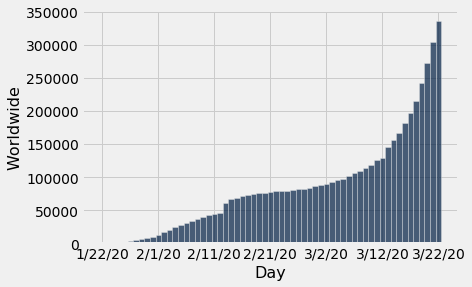

In [48]:
total_confirmed = countries_by_day.select('Day')
total_confirmed['Worldwide'] = countries_by_day.sum_rows()
print('Total confirmed', total_confirmed.last('Worldwide'))
total_confirmed.obar()

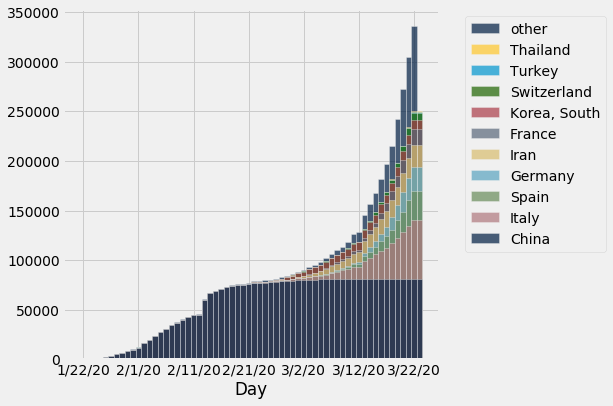

In [49]:
# Breaking this picture down by largest caseloads

countries_by_day.stackbar(10, height=6)

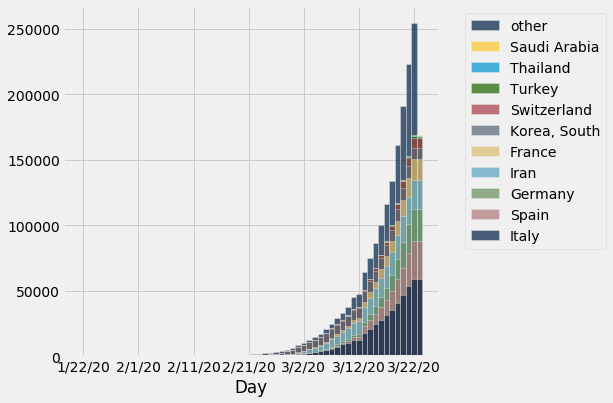

In [50]:
# Taking China out of the picture
countries_by_day.drop('China').stackbar(10, height=6)

In [51]:
# Recent picture of countries with most cases
countries_by_day.top(15).take[-10:]

Day,China,Italy,Spain,Germany,Iran,France,"Korea, South",Switzerland,Turkey,Thailand,Saudi Arabia,Taiwan*,US,United Kingdom,Netherlands
3/14/20,80977,21157,6391,4585,12729,4487,8086,1359,5,82,103,53,2727,1144,962
3/15/20,81003,24747,7798,5795,13938,4523,8162,2200,6,114,103,59,3499,1145,1138
3/16/20,81033,27980,9942,7272,14991,6668,8236,2200,18,147,118,67,4632,1551,1416
3/17/20,81058,31506,11748,9257,16169,7699,8320,2700,47,177,171,77,6421,1960,1711
3/18/20,81102,35713,13910,12327,17361,9105,8413,3028,98,212,171,100,7783,2642,2058
3/19/20,81156,41035,17963,15320,18407,10947,8565,4075,192,272,274,108,13677,2716,2467
3/20/20,81250,47021,20410,19848,19644,12726,8652,5294,359,322,344,135,19100,4014,3003
3/21/20,81305,53578,25374,22213,20610,14431,8799,6575,670,411,392,153,25489,5067,3640
3/22/20,81397,59138,28768,24873,21638,16176,8897,7245,1236,599,511,169,33272,5741,4216
3/23/20,81439,59138,28768,24873,21638,16044,8897,7245,1236,599,511,169,nan,5741,4216


In [52]:
total_confirmed.trend().take[-10:]

Day,Worldwide,new,% new,rate
3/14/20,156094,10901,6.98%,1.07508
3/15/20,167446,11352,6.78%,1.07273
3/16/20,181527,14081,7.76%,1.08409
3/17/20,197142,15615,7.92%,1.08602
3/18/20,214910,17768,8.27%,1.09013
3/19/20,242708,27798,11.45%,1.12935
3/20/20,272166,29458,10.82%,1.12137
3/21/20,304524,32358,10.63%,1.11889
3/22/20,335955,31431,9.36%,1.10321
3/23/20,nan,nan,nan%,nan


In [53]:
project_trend(total_confirmed.trend().take[-10:], 10).show()

Day,Worldwide,new,% new,rate
3/14/20,156094,10901,6.98%,1.07508
3/15/20,167446,11352,6.78%,1.07273
3/16/20,181527,14081,7.76%,1.08409
3/17/20,197142,15615,7.92%,1.08602
3/18/20,214910,17768,8.27%,1.09013
3/19/20,242708,27798,11.45%,1.12935
3/20/20,272166,29458,10.82%,1.12137
3/21/20,304524,32358,10.63%,1.11889
3/22/20,335955,31431,9.36%,1.10321
3/23/20,nan,nan,nan%,nan


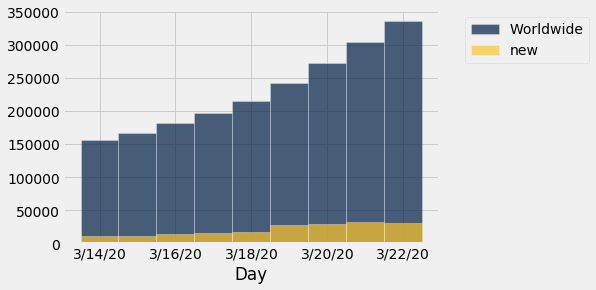

In [54]:
project_trend(total_confirmed.trend().take[-10:], 10).select(range(3)).bar('Day')

In [55]:
countries_by_day.top(5).trend().take[-10:]

Day,China,new China,% newChina,rate China,Italy,new Italy,% newItaly,rate Italy,Spain,new Spain,% newSpain,rate Spain,Germany,new Germany,% newGermany,rate Germany,Iran,new Iran,% newIran,rate Iran
3/14/20,80977,32,0.04%,1.0004,21157,3497,16.53%,1.19802,6391,1159,18.13%,1.22152,4585,910,19.85%,1.24762,12729,1365,10.72%,1.12012
3/15/20,81003,26,0.03%,1.00032,24747,3590,14.51%,1.16968,7798,1407,18.04%,1.22015,5795,1210,20.88%,1.2639,13938,1209,8.67%,1.09498
3/16/20,81033,30,0.04%,1.00037,27980,3233,11.55%,1.13064,9942,2144,21.57%,1.27494,7272,1477,20.31%,1.25487,14991,1053,7.02%,1.07555
3/17/20,81058,25,0.03%,1.00031,31506,3526,11.19%,1.12602,11748,1806,15.37%,1.18165,9257,1985,21.44%,1.27296,16169,1178,7.29%,1.07858
3/18/20,81102,44,0.05%,1.00054,35713,4207,11.78%,1.13353,13910,2162,15.54%,1.18403,12327,3070,24.90%,1.33164,17361,1192,6.87%,1.07372
3/19/20,81156,54,0.07%,1.00067,41035,5322,12.97%,1.14902,17963,4053,22.56%,1.29137,15320,2993,19.54%,1.2428,18407,1046,5.68%,1.06025
3/20/20,81250,94,0.12%,1.00116,47021,5986,12.73%,1.14588,20410,2447,11.99%,1.13622,19848,4528,22.81%,1.29556,19644,1237,6.30%,1.0672
3/21/20,81305,55,0.07%,1.00068,53578,6557,12.24%,1.13945,25374,4964,19.56%,1.24321,22213,2365,10.65%,1.11916,20610,966,4.69%,1.04918
3/22/20,81397,92,0.11%,1.00113,59138,5560,9.40%,1.10377,28768,3394,11.80%,1.13376,24873,2660,10.69%,1.11975,21638,1028,4.75%,1.04988
3/23/20,81439,42,0.05%,1.00052,59138,0,0.00%,1,28768,0,0.00%,1,24873,0,0.00%,1,21638,0,0.00%,1


### Confirmed cases in one country

In [56]:
w = widgets.Dropdown(
    options=countries_by_day.categories,
    value='US',
    # rows=10,
    description='Country:',
    disabled=False
)
w

Dropdown(description='Country:', index=172, options=('Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',…

In [57]:
country = w.value

In [58]:
country_trend = countries_by_day.extract(country).trend()
after(country_trend, '3/1/20').show()

Day,US,new,% new,rate
3/1/20,74,6,0.0810811,1.08824
3/2/20,98,24,0.244898,1.32432
3/3/20,118,20,0.169492,1.20408
3/4/20,149,31,0.208054,1.26271
3/5/20,217,68,0.313364,1.45638
3/6/20,262,45,0.171756,1.20737
3/7/20,402,140,0.348259,1.53435
3/8/20,518,116,0.223938,1.28856
3/9/20,583,65,0.111492,1.12548
3/10/20,959,376,0.392075,1.64494


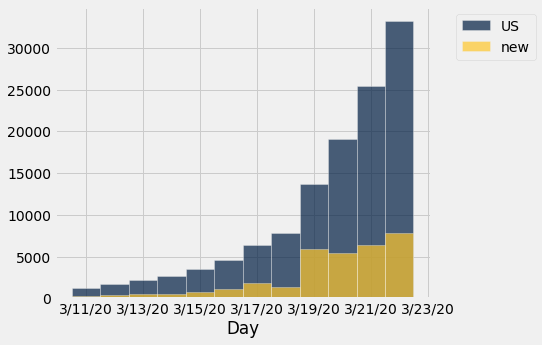

In [59]:
recent = after(country_trend,'3/11/20')
recent.extract([country, 'new']).bar('Day', height=5)

In [60]:
projection = project_trend(recent, 10)
projection.show()

Day,US,new,% new,rate
3/11/20,1281,322,0.251366,1.33577
3/12/20,1663,382,0.229705,1.2982
3/13/20,2179,516,0.236806,1.31028
3/14/20,2727,548,0.200953,1.25149
3/15/20,3499,772,0.220634,1.28309
3/16/20,4632,1133,0.244603,1.32381
3/17/20,6421,1789,0.278617,1.38623
3/18/20,7783,1362,0.174997,1.21212
3/19/20,13677,5894,0.430942,1.75729
3/20/20,19100,5423,0.283927,1.39651


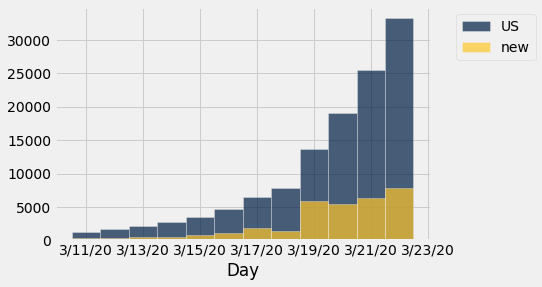

In [61]:
projection.extract([country, 'new']).bar('Day')

### State/Province level

What countries are further broken down by state

In [62]:
countries_with_states = list(np.unique(raw_confirmed.where(raw_confirmed['Province/State'] != 'nan')['Country/Region']))

cw = widgets.Dropdown(
    options=countries_with_states,
    value='US',
    # rows=10,
    description='Country:',
    disabled=False
)
cw

Dropdown(description='Country:', index=7, options=('Australia', 'Canada', 'China', 'Cruise Ship', 'Denmark', '…

In [63]:
sel_country = cw.value
sel_country

'US'

In [64]:
raw_sel_confirmed = raw_confirmed.where('Country/Region', sel_country)
raw_sel_confirmed

Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20
Washington,US,47.4009,-121.49,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,267,366,442,568,572,643,904,1076,1014,1376,1524,1793,1996,1996
New York,US,42.1657,-74.9481,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,173,220,328,421,525,732,967,1706,2495,5365,8310,11710,15793,15793
California,US,36.1162,-119.682,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,144,177,221,282,340,426,557,698,751,952,1177,1364,1642,1642
Massachusetts,US,42.2302,-71.5301,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,92,95,108,123,138,164,197,218,218,328,413,525,646,646
Diamond Princess,US,35.4437,139.638,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36,36,42,42,44,44,44,45,45,45,45,45,45,45,45,46,46,46,46,46,46,47,47,47,47,49,49,49,49
Grand Princess,US,37.6489,-122.665,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,21,21,21,21,21,21,21,21,21,20,21,21,22,23,23,30,30
Georgia,US,33.0406,-83.6431,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17,23,31,42,66,99,121,146,199,287,420,507,600,600
Colorado,US,39.0598,-105.311,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15,34,45,49,101,131,160,160,184,277,363,390,476,476
Florida,US,27.7663,-81.6868,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15,28,35,50,76,115,155,216,314,417,563,659,830,830
New Jersey,US,40.2989,-74.521,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15,23,29,29,69,98,178,267,267,742,890,1327,1914,1914


In [65]:
raw_by_State_confirmed = raw_sel_confirmed.where(raw_sel_confirmed.apply(is_state, 'Province/State'))
states_by_day = TimeTable.transpose(raw_by_State_confirmed.drop(['Country/Region', 'Lat', 'Long']), 'Province/State', 'Day')
recent_by_State = after(states_by_day,'3/10/20')
recent_by_State = recent_by_State.order_cols()
recent_by_State.show()

Day,New York,Washington,New Jersey,California,Illinois,Michigan,Louisiana,Florida,Massachusetts,Texas,Georgia,Pennsylvania,Tennessee,Colorado,Wisconsin,Ohio,North Carolina,Maryland,Connecticut,Virginia,Mississippi,Indiana,South Carolina,Nevada,Utah,Minnesota,Arkansas,Oregon,Arizona,Alabama,District of Columbia,Missouri,Kentucky,Iowa,Maine,Rhode Island,Oklahoma,New Hampshire,Kansas,New Mexico,Vermont,Nebraska,Diamond Princess,Hawaii,Delaware,Idaho,Montana,Grand Princess,North Dakota,Guam,Wyoming,Puerto Rico,Alaska,South Dakota,West Virginia,Virgin Islands,United States Virgin Islands,US
3/10/20,173,267,15,144,12,0,1,15,92,13,17,12,7,15,3,3,7,8,2,7,0,6,7,4,2,3,0,15,6,0,5,1,6,8,0,3,2,4,1,0,1,3,46,2,0,0,0,21,0,0,0,0,0,0,0,0,0,0
3/11/20,220,366,23,177,25,2,6,28,95,21,23,16,9,34,6,4,7,9,3,9,0,11,10,7,3,5,1,19,9,0,10,1,8,13,0,5,2,5,1,3,1,5,46,2,1,0,1,21,0,0,0,0,0,8,0,0,0,0
3/12/20,328,442,29,221,32,2,19,35,108,27,31,22,18,45,8,5,15,12,5,17,1,13,12,14,5,9,6,24,9,0,10,1,10,16,0,5,2,6,1,5,2,10,46,2,1,0,1,21,1,0,1,0,0,8,0,0,0,0
3/13/20,421,568,29,282,46,16,36,50,123,43,42,41,26,49,19,13,17,18,11,30,1,13,13,17,9,14,6,30,9,5,10,2,14,17,1,14,2,6,5,10,2,13,46,2,4,1,1,21,1,0,1,0,1,8,0,0,0,0
3/14/20,525,572,69,340,64,25,77,76,138,57,66,47,32,101,27,26,24,26,22,41,6,16,19,21,10,21,12,32,12,6,10,4,14,17,3,20,4,7,8,10,5,14,46,4,6,2,5,21,1,0,2,3,1,9,0,1,0,0
3/15/20,732,643,98,426,93,33,91,115,164,72,99,66,39,131,32,37,33,32,24,45,10,20,28,24,28,35,16,36,13,12,16,5,20,18,12,20,7,13,8,13,8,17,46,6,7,5,7,21,1,3,3,5,1,9,0,1,0,0
3/16/20,967,904,178,557,105,53,136,155,197,85,121,77,52,160,47,50,38,41,30,49,13,25,33,45,39,54,22,39,18,29,22,6,21,23,17,21,10,17,11,17,12,18,47,7,8,5,7,20,1,3,3,5,1,10,0,1,0,0
3/17/20,1706,1076,267,698,161,65,196,216,218,110,146,112,74,160,72,67,64,60,68,67,21,30,47,56,51,60,22,66,20,39,22,11,26,23,32,23,19,26,18,23,12,21,47,10,16,8,9,21,3,3,11,5,3,11,1,2,0,0
3/18/20,2495,1014,267,751,162,83,257,314,218,173,199,152,79,184,92,86,70,85,68,77,34,39,47,55,51,77,33,68,27,46,31,18,27,29,42,33,19,26,18,23,18,24,47,14,19,9,11,21,6,5,15,5,6,11,1,2,0,0
3/19/20,5365,1376,742,952,422,334,392,417,328,260,287,206,154,277,159,119,123,107,159,99,50,60,81,95,80,89,62,88,45,78,40,31,37,44,52,44,44,44,34,35,22,29,47,16,30,11,11,22,18,12,18,5,9,11,2,3,0,0


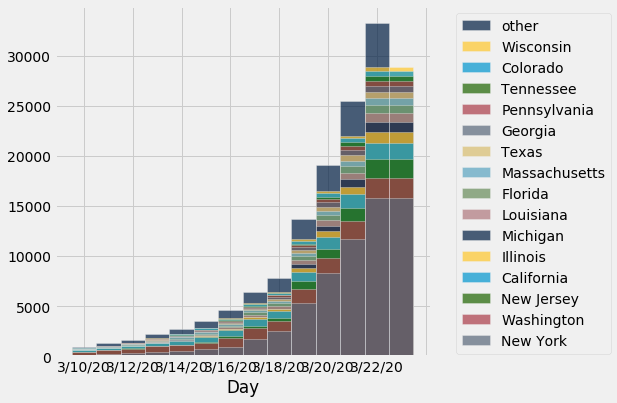

In [66]:
recent_by_State.stackbar(15, height=6)

# State level analysis

In [67]:
sw = widgets.Dropdown(
    options=recent_by_State.categories,
    value=recent_by_State.categories[0],
    # rows=10,
    description='State/Province:',
    disabled=False
)
sw

Dropdown(description='State/Province:', options=('New York', 'Washington', 'New Jersey', 'California', 'Illino…

In [75]:
state = sw.value

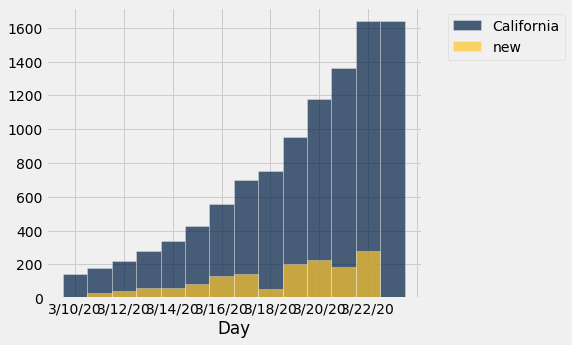

In [76]:
state_trend = recent_by_State.extract(state).trend()
state_trend.extract(['Day', state, 'new']).bar('Day', height=5)

In [77]:
project_trend(state_trend, 10).show()

Day,California,new,% new,rate
3/10/20,144,nan,nan,nan
3/11/20,177,33,0.186441,1.22917
3/12/20,221,44,0.199095,1.24859
3/13/20,282,61,0.216312,1.27602
3/14/20,340,58,0.170588,1.20567
3/15/20,426,86,0.201878,1.25294
3/16/20,557,131,0.235189,1.30751
3/17/20,698,141,0.202006,1.25314
3/18/20,751,53,0.0705726,1.07593
3/19/20,952,201,0.211134,1.26764


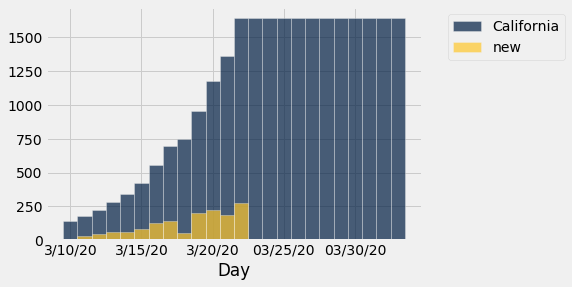

In [78]:
project_trend(state_trend, 10).extract([state, 'new']).bar('Day')

### County level reporting - not there recently

In [79]:
raw_US_confirmed = raw_confirmed.where('Country/Region', 'US')
raw_US_by_County_confirmed = raw_US_confirmed.where(raw_US_confirmed.apply(is_county, 'Province/State'))
raw_US_by_County_confirmed['State'] = raw_US_by_County_confirmed.apply(getstate, 'Province/State')
raw_US_by_County_confirmed['County'] = raw_US_by_County_confirmed.apply(getcounty, 'Province/State')
raw_US_by_County_confirmed.move_to_start('County')
raw_US_by_County_confirmed.move_to_start('State')
raw_US_by_County_confirmed.sort('State')

State,County,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20
AZ,Pima,"Pima, AZ",US,32.0575,-111.666,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,nan
AZ,Pinal County,"Pinal County, AZ",US,32.8162,-111.284,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,nan
AZ,Maricopa County,"Maricopa County, AZ",US,33.2918,-112.429,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,2,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,nan
CA,Solano,"Solano, CA",US,38.3105,-121.902,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,nan
CA,Santa Cruz,"Santa Cruz, CA",US,37.0454,-121.958,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,nan
CA,Napa,"Napa, CA",US,38.5025,-122.265,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,nan
CA,Ventura,"Ventura, CA",US,34.3705,-119.139,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,nan
CA,Shasta County,"Shasta County, CA",US,40.7909,-121.847,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,nan
CA,Fresno County,"Fresno County, CA",US,36.9859,-119.232,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,nan
CA,Riverside County,"Riverside County, CA",US,33.9533,-117.396,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,nan


In [73]:
raw_US_by_County_confirmed.where('State', 'CA')

State,County,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20
CA,Solano,"Solano, CA",US,38.3105,-121.902,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,nan
CA,Santa Cruz,"Santa Cruz, CA",US,37.0454,-121.958,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,nan
CA,Napa,"Napa, CA",US,38.5025,-122.265,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,nan
CA,Ventura,"Ventura, CA",US,34.3705,-119.139,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,nan
CA,Shasta County,"Shasta County, CA",US,40.7909,-121.847,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,nan
CA,Fresno County,"Fresno County, CA",US,36.9859,-119.232,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,nan
CA,Riverside County,"Riverside County, CA",US,33.9533,-117.396,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,nan
CA,Alameda County,"Alameda County, CA",US,37.6017,-121.719,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,2,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,nan
CA,Madera County,"Madera County, CA",US,37.2519,-119.696,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,nan
CA,Yolo County,"Yolo County, CA",US,38.7646,-121.902,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,nan


In [74]:
raw_CA_county = raw_US_by_County_confirmed.where('State', 'CA').drop(['State', 'Province/State', 'Country/Region', 'Lat', 'Long'])
CA_county_by_day = TimeTable.transpose(raw_CA_county, 'County', 'Day')
CA_county_by_day.show()

Day,Solano,Santa Cruz,Napa,Ventura,Shasta County,Fresno County,Riverside County,Alameda County,Madera County,Yolo County,Santa Clara County,San Francisco County,Contra Costa County,Orange County,Placer County,San Mateo,Sonoma County,Humboldt County,Sacramento County,San Diego County,San Benito,Los Angeles,Marin,Calaveras,Stanislaus,San Joaquin
1/22/20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1/23/20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1/24/20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1/25/20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1/26/20,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
1/27/20,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
1/28/20,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
1/29/20,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
1/30/20,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
1/31/20,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
